In [1]:
import os
import astropy.io.fits as fits
import numpy as np
import scipy
import scipy.ndimage as ndi
import matplotlib.pylab as plt
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pyklip.klip
import pyklip.fakes as fakes
import pyklip.fm as fm
import pyklip.instruments.Instrument as Instrument
import pyklip.fmlib.fmpsf as fmpsf
import pyklip.fitpsf as fitpsf

In [2]:
filtername = "f300m"
data_folder = 'old_simulated_data/'

# read in roll 1
with fits.open(data_folder+"NIRCam_target_Roll1_{0}.fits".format(filtername)) as hdulist:
    roll1_cube = hdulist[0].data
    print(roll1_cube.shape)

# read in roll 2
with fits.open(data_folder+"NIRCam_target_Roll2_{0}.fits".format(filtername)) as hdulist:
    roll2_cube = hdulist[0].data   
    print(roll2_cube.shape)
    
# read in unocculted PSF
with fits.open(data_folder+"NIRCam_unocculted_{0}.fits".format(filtername)) as hdulist:
    psf_cube = hdulist[0].data 
    print(psf_cube.shape)  

# combine the two rows
full_seq = np.concatenate([roll1_cube, roll2_cube], axis=0)

# two rolls are offset 10 degrees, this is the right sign (trust me)
pas = np.append([0 for _ in range(roll1_cube.shape[0])], [10 for _ in range(roll2_cube.shape[0])])

# for each image, the (x,y) center where the star is is just the center of the image
centers = np.array([np.array(frame.shape)/2. for frame in full_seq])

# give it some names, just in case we want to refer to them
filenames = np.append(["roll1_{0}".format(i) for i in range(roll1_cube.shape[0])],
                      ["roll2_{0}".format(i) for i in range(roll1_cube.shape[0])])

# create the GenericData object. This will standardize the data for pyKLIP
dataset = Instrument.GenericData(full_seq, centers, IWA=4, parangs=pas, filenames=filenames)
dataset.flipx = False # get the right handedness of the data

(6, 101, 101)
(6, 101, 101)
(6, 101, 101)


In [3]:
# collapse reference psf in time
psf_frame = np.nanmean(psf_cube, axis=0)

# find the centroid
bestfit = fakes.gaussfit2d(psf_frame, 71, 30, searchrad=3, guessfwhm=2, guesspeak=1, refinefit=True)

psf_xcen, psf_ycen = bestfit[2:4]

# recenter PSF to that location
x, y = np.meshgrid(np.arange(-20,20.1,1), np.arange(-20,20.1,1))
x += psf_xcen
y += psf_ycen

psf_stamp = scipy.ndimage.map_coordinates(psf_frame, [y,x])

70.45855749153525 29.8360856033007


In [4]:
# Read in the transmission profile csv
mask210 = pd.read_csv("MASK210R.csv", names = ["rad_dist", "trans"])

# Create the throughput correction function
def transmission_corrected(input_stamp, input_dx, input_dy):

    """
    Args:
        input_stamp (array): 2D array of the region surrounding the fake planet injection site
        input_dx (array): 2D array specifying the x distance of each stamp pixel from the center
        input_dy (array): 2D array specifying the y distance of each stamp pixel from the center
        
    Returns:
        output_stamp (array): 2D array of the throughput corrected planet injection site.
        """

    # Calculate the distance of each pixel in the input stamp from the center
    distance_from_center = np.sqrt((input_dx) ** 2 + (input_dy) ** 2)

    # Interpolate to find the transmission value for each pixel in the input stamp (we need to turn the columns into arrays so np.interp can accept them)
    distance = np.array(mask210["rad_dist"])
    transmission = np.array(mask210["trans"])
    
    # Calculate the distance in pixels
    distance_pix = mask210['rad_dist']/0.063

    trans_at_dist = np.interp(distance_from_center, distance_pix, transmission)

    # Reshape the interpolated array to have the same dimensions as the input stamp
    transmission_stamp = trans_at_dist.reshape(input_stamp.shape)

    # Make the throughput correction
    output_stamp = transmission_stamp * input_stamp

    return output_stamp

In [5]:
# Injecting fake at 7 pix

psf_stamp_input = np.array([psf_stamp for j in range(12)])
planet_sep = 7
input_contrast = 0.0007453333542335642
pa = 270


planet_flux = psf_stamp_input * input_contrast

fakes.inject_planet(frames=dataset.input, centers=dataset.centers, inputflux=planet_flux, astr_hdrs=dataset.wcs, radius=planet_sep, pa=pa, field_dependent_correction=transmission_corrected)


In [6]:
# setup FM guesses
numbasis = np.array([1, 3, 10]) # KL basis cutoffs you want to try
guess_dx = 0 # in pxiels (positive is to the left)
guess_dy = 19.6 # in pixels (positive is up)
guesssep = 7 # estimate of separation in pixels
guesspa = 270 # estimate of position angle, in degrees
guessflux = 1e-4 # estimated contrast
guessspec = np.array([1]) # braodband, so don't need to guess spectrum

# initialize the FM Planet PSF class
fm_class = fmpsf.FMPlanetPSF(dataset.input.shape, numbasis, guesssep, guesspa, guessflux, np.array([psf_stamp]),
                             np.unique(dataset.wvs), spectrallib_units="contrast", spectrallib=[guessspec], field_dependent_correction = transmission_corrected)


/Users/jeaadams/opt/anaconda3/lib/python3.7/site-packages/scipy/interpolate/fitpack2.py:1133: UserWarning: 
The coefficients of the spline returned have been computed as the
minimal norm least-squares solution of a (numerically) rank deficient
system (deficiency=255). If deficiency is large, the results may be
inaccurate. Deficiency may strongly depend on the value of eps.
  warnings.warn(message)


In [7]:
# PSF subtraction parameters
# You should change these to be suited to your data!
outputdir = "./" # where to write the output files
prefix = "pyklipfm-b-ADI-k50m1" # fileprefix for the output files
annulus_bounds = [[guesssep-20, guesssep+20]] # one annulus centered on the planet
subsections = 1 # we are not breaking up the annulus
padding = 0 # we are not padding our zones
movement = 1 # basically, we want to use the other roll angle for ADI.

# run KLIP-FM
import pyklip.fm as fm
fm.klip_dataset(dataset, fm_class, outputdir=outputdir, fileprefix=prefix, numbasis=numbasis,
                annuli=annulus_bounds, subsections=subsections, padding=padding, movement=movement, maxnumbasis=50)

Begin align and scale images for each wavelength
Align and scale finished
Starting KLIP for sector 1/1 with an area of 1759.291886010284 pix^2
Time spent on last sector: 0s
Time spent since beginning: 0s
First sector: Can't predict remaining time

Closing threadpool
Writing KLIPed Images to directory /Users/jeaadams/jwst_trials


In [8]:
output_prefix = os.path.join(outputdir, prefix)
with fits.open(output_prefix + "-fmpsf-KLmodes-all.fits") as fm_hdu:
    # get FM frame, use KL=7
    fm_frame = fm_hdu[0].data[1]
    fm_centx = fm_hdu[0].header['PSFCENTX']
    fm_centy = fm_hdu[0].header['PSFCENTY']

with fits.open(output_prefix + "-klipped-KLmodes-all.fits") as data_hdu:
    # get data_stamp frame, use KL=7
    data_frame = data_hdu[0].data[1]
    data_centx = data_hdu[0].header["PSFCENTX"]
    data_centy = data_hdu[0].header["PSFCENTY"]

fitboxsize = 17
fma = fitpsf.FMAstrometry(guesssep, guesspa, fitboxsize)

# generate FM stamp
# padding should be greater than 0 so we don't run into interpolation problems
fma.generate_fm_stamp(fm_frame, [fm_centx, fm_centy], padding=5)

# generate data_stamp stamp
# not that dr=4 means we are using a 4 pixel wide annulus to sample the noise for each pixel
# exclusion_radius excludes all pixels less than that distance from the estimated location of the planet
fma.generate_data_stamp(data_frame, [data_centx, data_centy], dr=4, exclusion_radius=10)

/Users/jeaadams/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [9]:
output_prefix = os.path.join(outputdir, prefix)
with fits.open(output_prefix + "-fmpsf-KLmodes-all.fits") as fm_hdu:
    # get FM frame, use KL=7
    fm_frame = fm_hdu[0].data[1]
    fm_centx = fm_hdu[0].header['PSFCENTX']
    fm_centy = fm_hdu[0].header['PSFCENTY']

with fits.open(output_prefix + "-klipped-KLmodes-all.fits") as data_hdu:
    # get data_stamp frame, use KL=7
    data_frame = data_hdu[0].data[1]
    data_centx = data_hdu[0].header["PSFCENTX"]
    data_centy = data_hdu[0].header["PSFCENTY"]

fitboxsize = 17
fma = fitpsf.FMAstrometry(guesssep, guesspa, fitboxsize)

# generate FM stamp
# padding should be greater than 0 so we don't run into interpolation problems
fma.generate_fm_stamp(fm_frame, [fm_centx, fm_centy], padding=5)

# generate data_stamp stamp
# not that dr=4 means we are using a 4 pixel wide annulus to sample the noise for each pixel
# exclusion_radius excludes all pixels less than that distance from the estimated location of the planet
fma.generate_data_stamp(data_frame, [data_centx, data_centy], dr=4, exclusion_radius=10)

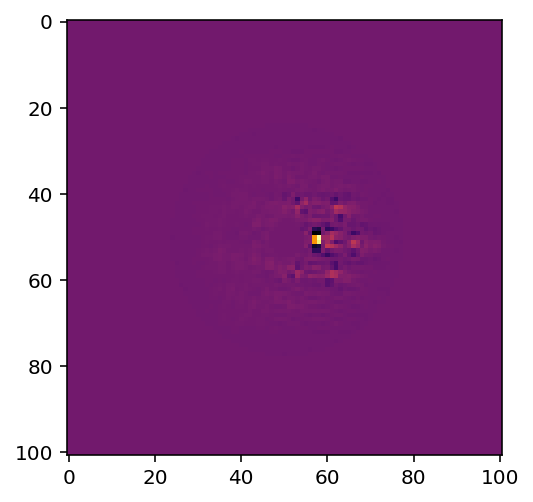

In [10]:
plt.imshow(fm_frame, cmap = 'inferno')

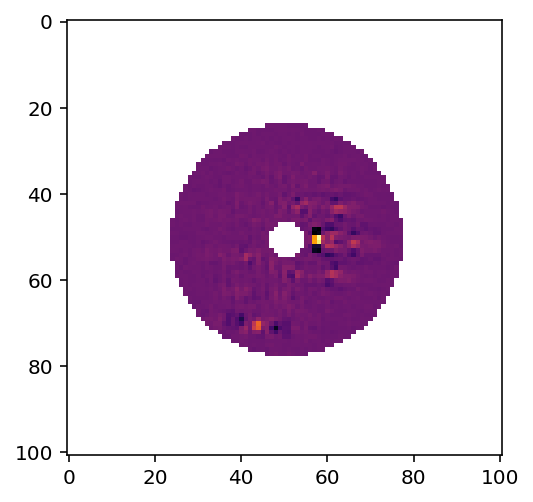

In [11]:
plt.imshow(data_frame, cmap = 'inferno')

In [12]:
# set kernel
corr_len_guess = 3. # in pixels, our guess for the correlation length
corr_len_label = r"$l$" # label for this variable.
fma.set_kernel("diag", [], [])

# set prior boundson parameters
x_range = 1.0 # pixels
y_range = 1.0 # pixels
flux_range = 1. # flux can vary by an order of magnitude
corr_len_range = 1. # between 0.3 and 30
fma.set_bounds(x_range, y_range, flux_range, [corr_len_range])

# run MCMC fit
fma.fit_astrometry(nwalkers=100, nburn=200, nsteps=800, numthreads=2)

Running burn in
Burn in finished. Now sampling posterior
MCMC sampler has finished


Text(0, 0.5, '$\\alpha$')

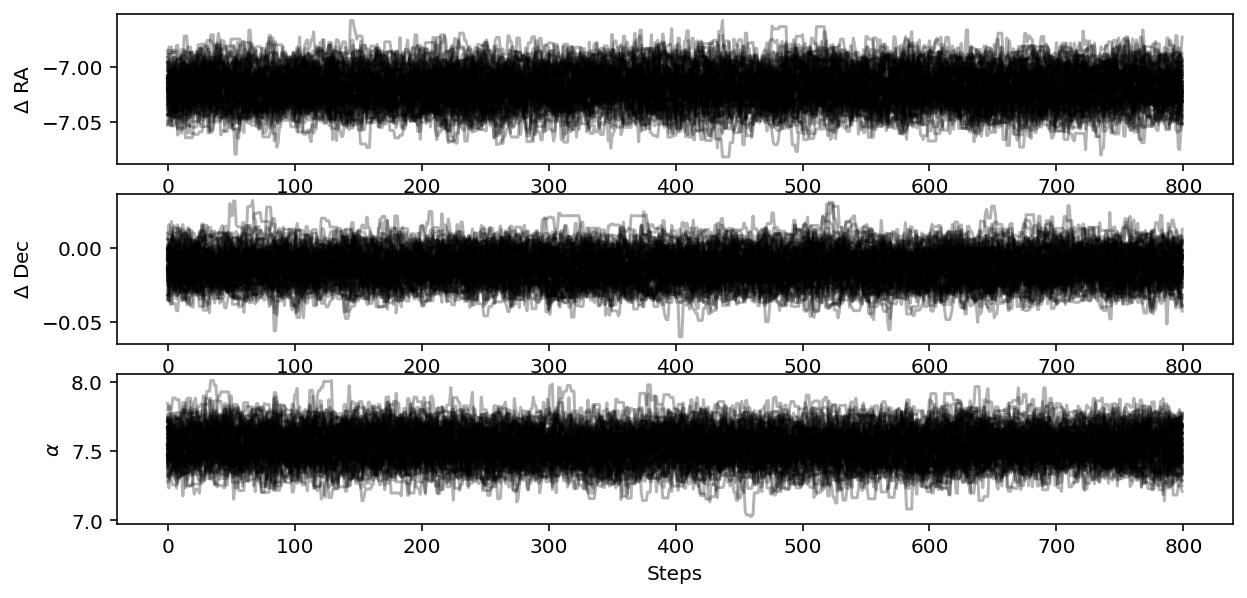

In [13]:
fig = plt.figure(figsize=(10,8))

# grab the chains from the sampler
chain = fma.sampler.chain

# plot RA offset
ax1 = fig.add_subplot(511)
ax1.plot(chain[:,:,0].T, '-', color='k', alpha=0.3)
ax1.set_xlabel("Steps")
ax1.set_ylabel(r"$\Delta$ RA")

# plot Dec offset
ax2 = fig.add_subplot(512)
ax2.plot(chain[:,:,1].T, '-', color='k', alpha=0.3)
ax2.set_xlabel("Steps")
ax2.set_ylabel(r"$\Delta$ Dec")

# plot flux scaling
ax3 = fig.add_subplot(513)
ax3.plot(chain[:,:,2].T, '-', color='k', alpha=0.3)
ax3.set_xlabel("Steps")
ax3.set_ylabel(r"$\alpha$")

# # plot hyperparameters.. we only have one for this example: the correlation length
# ax4 = fig.add_subplot(514)
# ax4.plot(chain[:,:,3].T, '-', color='k', alpha=0.3)
# ax4.set_xlabel("Steps")
# ax4.set_ylabel(r"$l$")

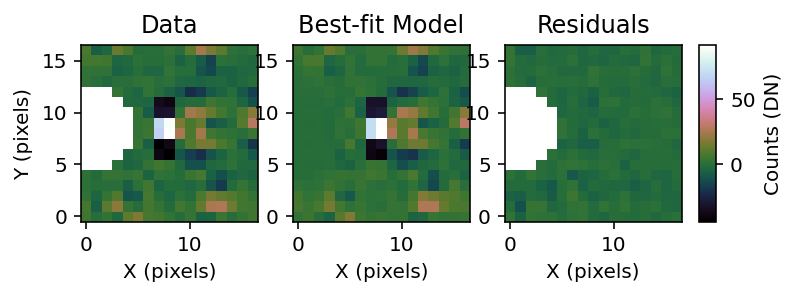

In [14]:
fig = plt.figure()
fig = fma.best_fit_and_residuals(fig=fig)

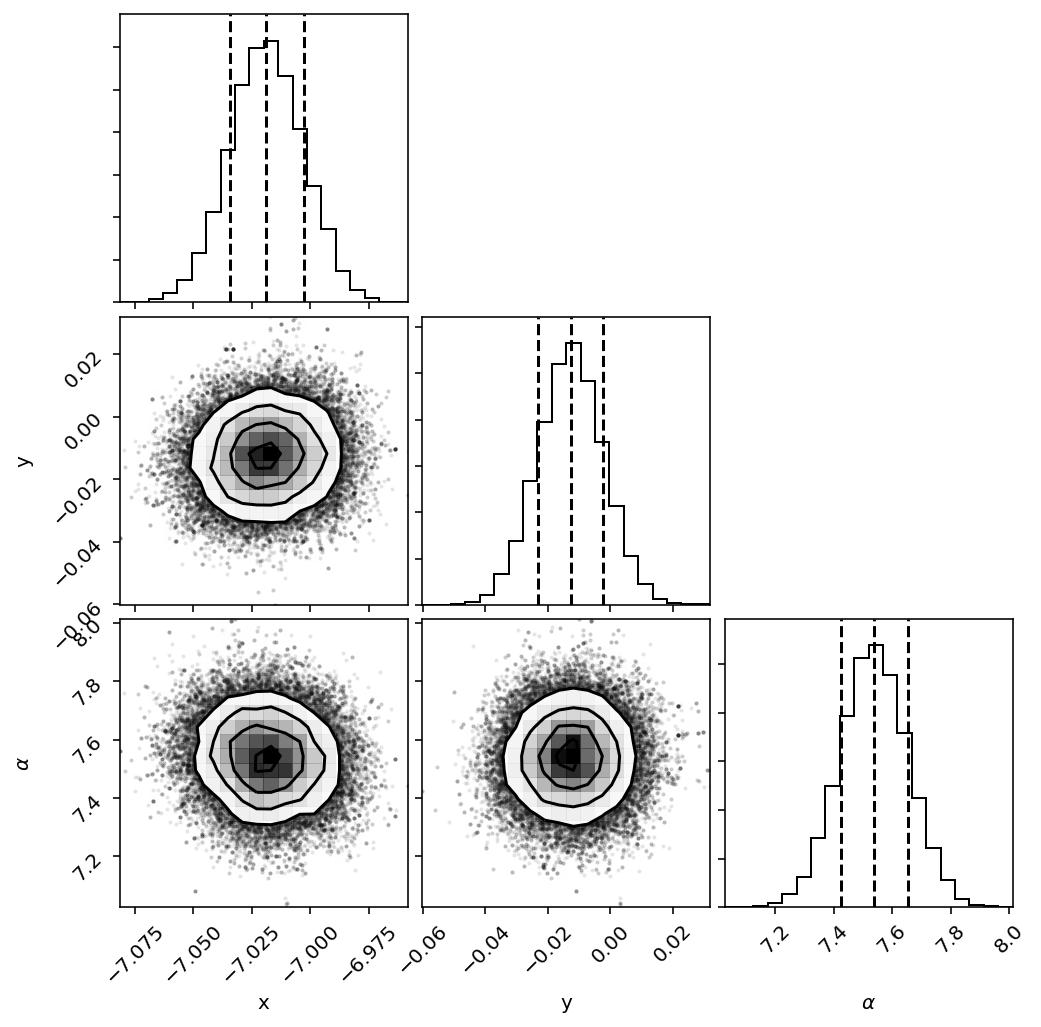

In [15]:
fig = fma.make_corner_plot()

In [16]:
print("\nPlanet Raw RA offset is {0} +/- {1}, Raw Dec offset is {2} +/- {3}".format(fma.raw_RA_offset.bestfit, fma.raw_RA_offset.error,
                                                                                    fma.raw_Dec_offset.bestfit, fma.raw_Dec_offset.error))

print("Planet Flux is {0} +/- {1}".format(fma.raw_flux.bestfit*guessflux, fma.raw_flux.error*guessflux))


Planet Raw RA offset is -7.01867531380794 +/- 0.01572005900649387, Raw Dec offset is -0.012595421305441334 +/- 0.01043440281422292
Planet Flux is 0.0007538251325274256 +/- 1.1512321116180458e-05


In [17]:
x_positions= [41,43]
y_positions= [54,70]

center_x = 50
center_y = 50

# calculate distance from center in x and y
p1_x_sep = abs(center_x - x_positions[0]) 
p1_y_sep = abs(center_y - y_positions[0]) 

p2_x_sep = abs(center_x - x_positions[1]) 
p2_y_sep = abs(center_y - y_positions[1]) 

# calculate straight line distance from center
p1_sep = np.sqrt((p1_x_sep)**2 + (p1_y_sep)**2)
p2_sep = np.sqrt((p2_x_sep)**2 + (p2_y_sep)**2)

print(p1_sep)
print(p2_sep)

9.848857801796104
21.18962010041709


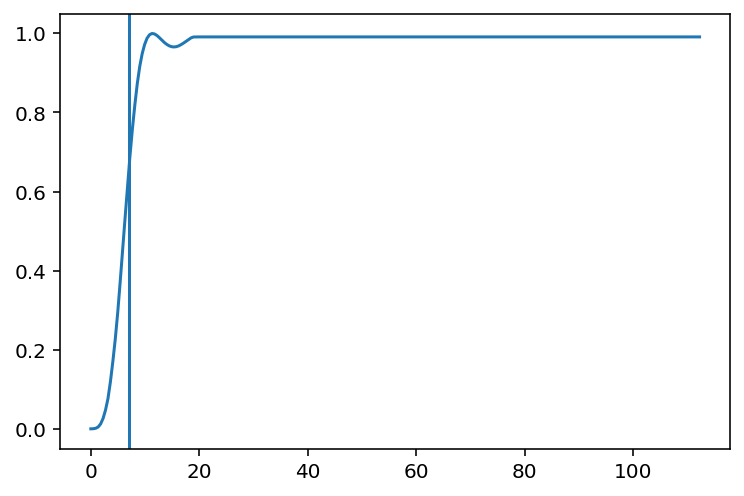

In [18]:
mask210['distance_pix'] = mask210['rad_dist']/0.063
plt.plot(mask210['distance_pix'], mask210['trans'])
plt.axvline(7)